# Figure 4: Nature of non- trans-spliced messengers

**Summary:**

This notebook compiles the scripts that were used to generate the Figure 4.

- **Panel a:** Gene expression and trans-splicing status.

- **Panel b:** Trans-splicing detection level

- **Panel c:** Poorly trans-spliced mRNA have a propensity to form a 5’ stem loop structure

---
<br>



## Import libraries

In [1]:
import pandas as pd
import numpy as np
import pyranges as pr

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from upsetplot import plot

## Settings for saving figures as pdf

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Set environmental constants

In [3]:
# Set path where files are stored
path = '/Volumes/elegans/rna_sequencing'

## Opening Dataset file

In [4]:
# Open dataset generated as part of the pre-processing step
dataset = pd.read_csv(f'{path}/dataset_+SSP+SL+HAIRPIN.tsv', sep='\t')

In [5]:
# open file generated as part of the pre-processing step (see part 3)
genes_start = pd.read_csv(f'{path}/start_positions_stats.tsv', sep='\t')

----

<br>

# Panel a: Gene expression and trans-splicing status

### a.1) ONT dataset (this study)

In [6]:
# load GTF file from WS270 release
WS270_gtf = pr.read_gtf(f'{path}/ref/c_elegans.PRJNA13758.WS270.canonical_geneset.gtf')
WS270_gtf = WS270_gtf.df

# Select protein coding entries
WS270_coding_genes = list(WS270_gtf[(WS270_gtf['gene_biotype']=='protein_coding') & (WS270_gtf['Feature']=='gene')]['gene_id'])

In [7]:
# ONT dataset (This paper)

ONT = pd.DataFrame()
idx=0
for gene, reads in dataset.groupby('gene'):
    
    ONT.loc[idx,'gene'] = gene
    ONT.loc[idx,'reads'] = int(len(reads))
    
    if len(reads[(reads['SL'].notna()) | (reads['softclip']==1)]) > 0:
        ONT.loc[idx,'trans-splicing'] = True
    else:
        ONT.loc[idx,'trans-splicing'] = False
    
    idx = idx+1

# convert name to wormbase ID
WS270_ref = pd.read_csv(f'{path}/ref/genes_coordinates.tsv', sep='\t')
ONT_to_WB = WS270_ref.set_index('CDS')['wormbaseID'].to_dict()
ONT['wormbaseID'] = ONT['gene'].map(ONT_to_WB)

IOStream.flush timed out


### a.2) Illumina dataset (from Tourasse et al, 2019)

In [8]:
ILLUMINA = pd.read_csv(f'{path}/ref/supp_gr.224626.117_Supplemental_Table_S4_SL_junctions.txt', sep='\t')

# convert name to wormbase ID (uses WS251 release)
ws251 = pd.read_csv(f'{path}/ref/c_elegans.PRJNA13758.WS251.geneIDs.txt', header=None)
ws251.columns = ['index','wormbaseID','name','CDS','status']
current_to_WB = ws251.set_index('name')['wormbaseID'].to_dict()

# CDS names to wormbase ID
CDS_to_WB = ws251.set_index('CDS')['wormbaseID'].to_dict()

In [9]:
def illumina_to_wormbase(gene_name):
    
    if gene_name in current_to_WB:
        return current_to_WB[gene_name]
    
    elif gene_name in CDS_to_WB:
        return CDS_to_WB[gene_name]
    
    else:
        return None

In [10]:
# apply function
ILLUMINA['wormbaseID'] =  ILLUMINA['gene'].apply(illumina_to_wormbase)

### a.3) Cross datasets

In [11]:
# List of genes found in either datasets 
genes_found_by_ONT = list(set(ONT[ONT['trans-splicing'] == True]['wormbaseID']))
genes_found_by_ILLUMINA = list(set(ILLUMINA['wormbaseID']))

def set_dataset_category(gene):
    
    if gene in genes_found_by_ONT and gene in genes_found_by_ILLUMINA:
        return 'BOTH'
    
    elif gene in genes_found_by_ONT :
        return 'ONT'
    
    elif gene in genes_found_by_ILLUMINA:
        return 'ILLUMINA'
    
    else:
        return 'NONE'

In [12]:
# create dataframe, indexed on gene names
cross = pd.DataFrame({'gene': WS270_coding_genes})

# Determine which gene is found in datasets
cross['set'] = cross['gene'].apply(set_dataset_category)

# Put rows in categorical order
cross['set'] = pd.Categorical(cross['set'], categories=["BOTH", "ONT", "ILLUMINA", "NONE"], ordered=True)
cross = cross.sort_values('set')

# add columns for generating upset plot (see figure 4a)
cross['ONT'] = cross['gene'].apply(lambda x: True if x in genes_found_by_ONT else False)
cross['ILLUMINA'] = cross['gene'].apply(lambda x: True if x in genes_found_by_ILLUMINA else False)

# add columns from ONT dataset with wormbase ID and number of reads 
cross = pd.concat([cross.set_index('gene'), ONT.set_index('wormbaseID')], axis=1)

In [13]:
cross

,set,ONT,ILLUMINA,gene,reads,trans-splicing
WBGene00022276,BOTH,True,True,Y74C9A.2,3753.0,True
WBGene00013329,BOTH,True,True,Y57G11C.40,11.0,True
WBGene00013304,BOTH,True,True,Y57G11C.6,6.0,True
WBGene00013303,BOTH,True,True,Y57G11C.5,36.0,True
WBGene00013302,BOTH,True,True,Y57G11C.4,182.0,True
...,...,...,...,...,...,...
WBGene00005508,NONE,False,False,NaN,NaN,NaN
WBGene00005507,NONE,False,False,NaN,NaN,NaN
WBGene00303370,NONE,False,False,NaN,NaN,NaN
WBGene00014679,NONE,False,False,NaN,NaN,NaN


### a.4) Compare datasets 

In [14]:
# looking solely at genes found in our dataset
ont_expr = cross[cross['reads']>0]

# generate and count categories

_BOTH = len(ont_expr[(ont_expr['ILLUMINA']==True)&(ont_expr['ONT']==True)])
print(f'Genes found trans-spliced in both datasets: {_BOTH}')

_ONT = len(ont_expr[(ont_expr['ILLUMINA']==False)&(ont_expr['ONT']==True)])
print(f'Genes found trans-spliced in ONT dataset only: {_ONT}')

_ILLUMINA = len(ont_expr[(ont_expr['ILLUMINA']==True)&(ont_expr['ONT']==False)])
print(f'Genes found trans-spliced in Illumina dataset only: {_ILLUMINA}')

_NONE = len(ont_expr[(ont_expr['ILLUMINA']==False)&(ont_expr['ONT']==False)])
print(f'Genes not found trans-spliced in either dataset: {_NONE}')

Genes found trans-spliced in both datasets: 16255
Genes found trans-spliced in ONT dataset only: 1535
Genes found trans-spliced in Illumina dataset only: 139
Genes not found trans-spliced in either dataset: 91


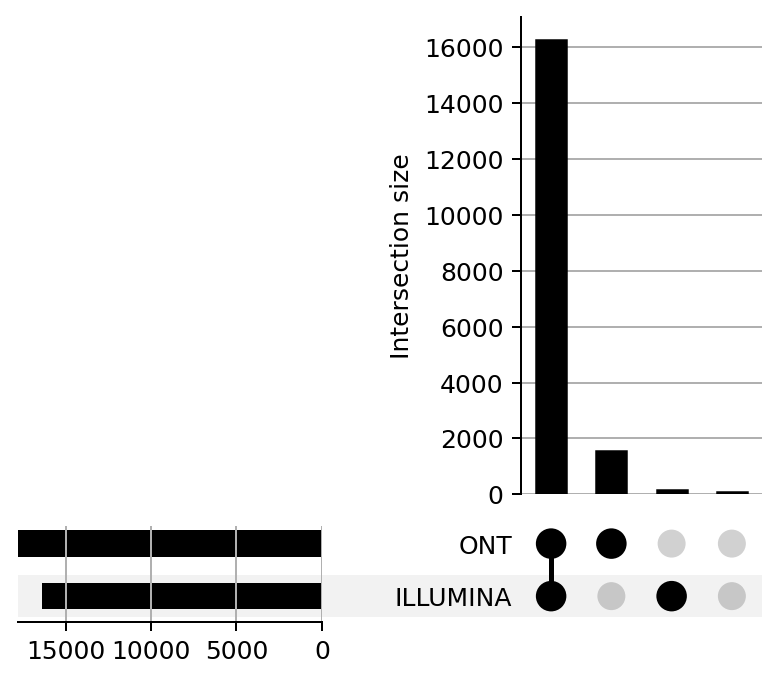

In [15]:
# Count genes per set
upset_cat = ont_expr.groupby(['ILLUMINA','ONT']).size()

# Show upset plot
p = plot(upset_cat, fig=plt.figure(figsize=(8,8), dpi=180), sort_categories_by=None, facecolor='k', sort_by='cardinality', totals_plot_elements=5, intersection_plot_elements=8)

# Save plot
plt.savefig('Fig4.a-upset_plot.png', dpi=800, bbox_inches='tight')

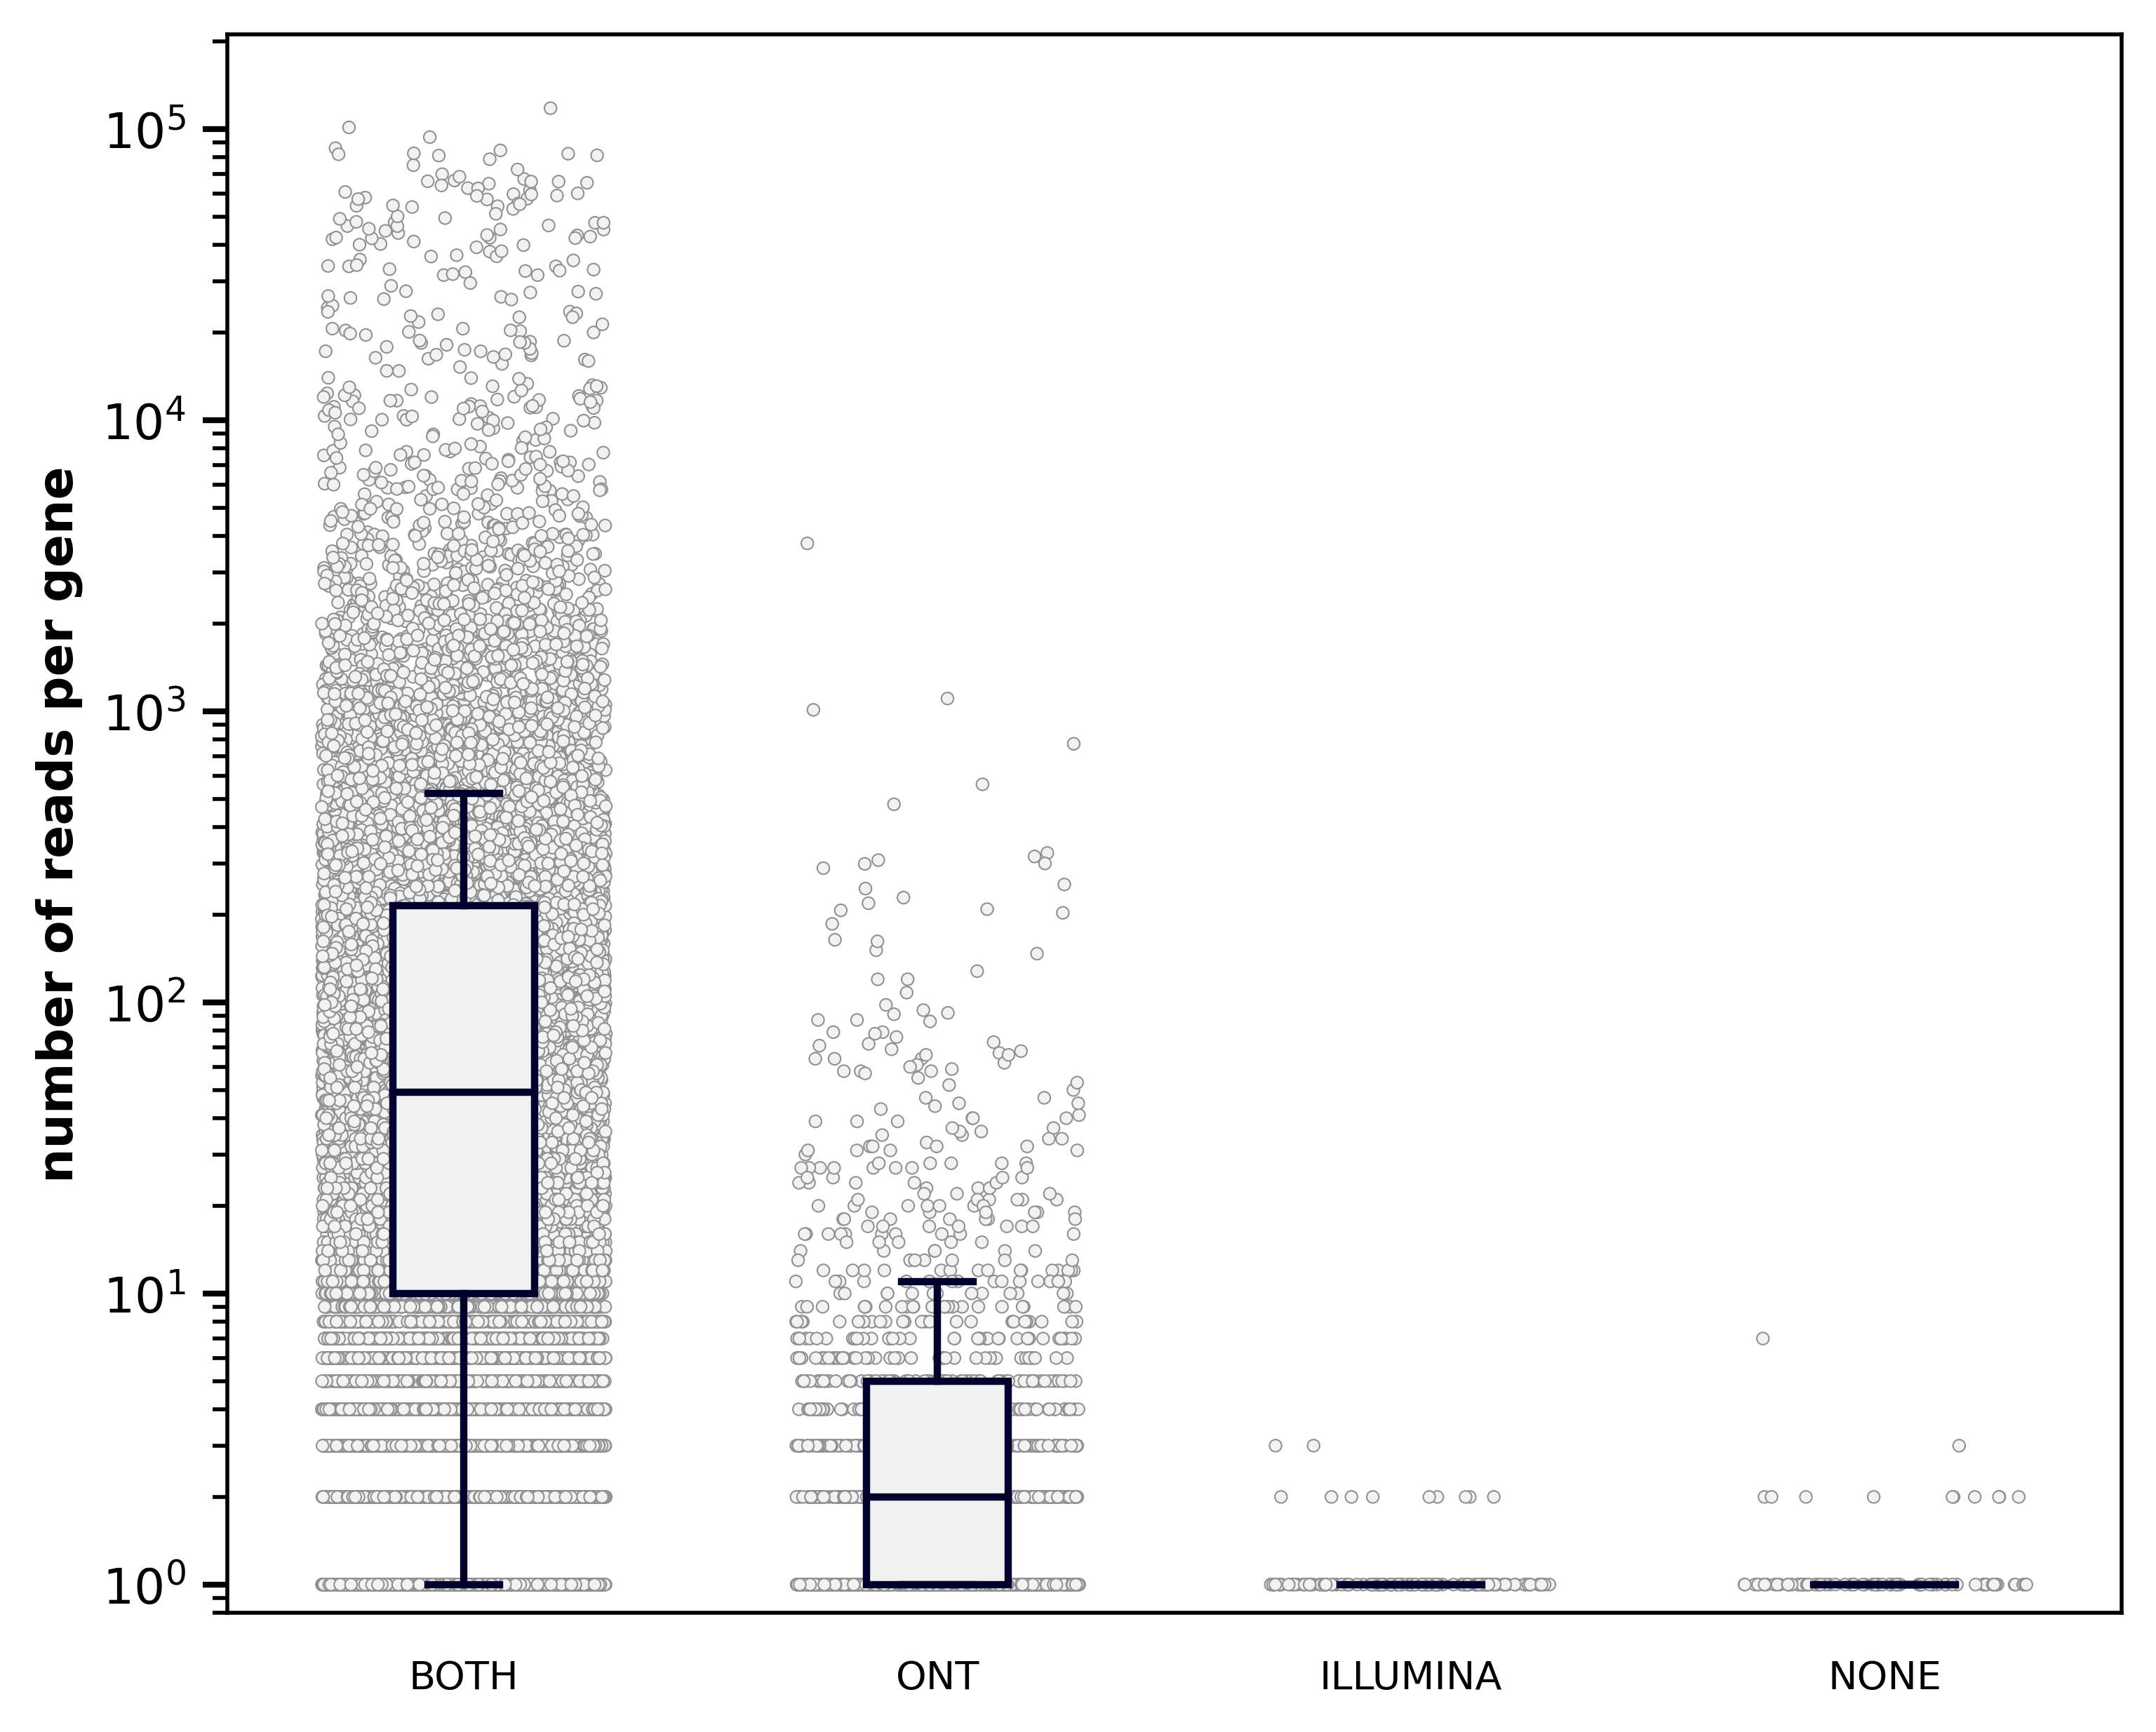

In [16]:
# create figure
%matplotlib inline
fig = plt.figure(figsize=(6, 5), dpi=500)

# create a rectangle for the new axis
rect = 0.1 ,0.1, 0.9, 0.9

# create a new axis
log_ax = fig.add_axes(rect)

# log first
log_ax.set_yscale("log")

# Stripplot
col = ['#f2f2f2','#f2f2f2','#f2f2f2','#f2f2f2']
ax = sns.stripplot(x='set', y='reads', data=ont_expr, palette=col, linewidth=0.3, jitter=0.3, size=2.5, alpha=1, zorder=0)

# Boxplot
PROPS = {'boxprops':{'edgecolor':'#03012d'},'medianprops':{'color':'#03012d'},'whiskerprops':{'color':'#03012d'},'capprops':{'color':'#03012d'}}
sns.boxplot(x='set', y='reads', data=ont_expr, fliersize=0, palette=col, width=0.3, zorder=1, **PROPS )

# Plot settings
log_ax.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5, bottom=False, left=False)
log_ax.set_ylim(bottom= 0.8)
log_ax.tick_params(axis='y', which ='minor', direction='out', length=3, width=0.8, colors='black', grid_alpha=0.5, left=True)
log_ax.tick_params(axis='y', which ='major', direction='out', length=5, width=1.2, colors='black', grid_alpha=0.5, left=True)

plt.xticks(size=8)
plt.xlabel('')
plt.ylabel('number of reads per gene', weight='bold')

# save
plt.savefig('Fig4.a-gene_expression_by_sets.png', dpi=800, bbox_inches='tight')

<br>

<font size="4">**Figure 4.a:**<br></font>
Gene expression and trans splicing status. We grouped gene in the C. elegans genome for which a direct cDNA read was obtained in this study according to the presence of evidence of trans splicing in this study and/or in the compendium of RNA-seq we previously analysed (Tourasse, 2017). For each gene we plotted the number of Nanopore reads we obtained as a proxy for gene expression level.

<br>

# Panel b: Trans-splicing detection level

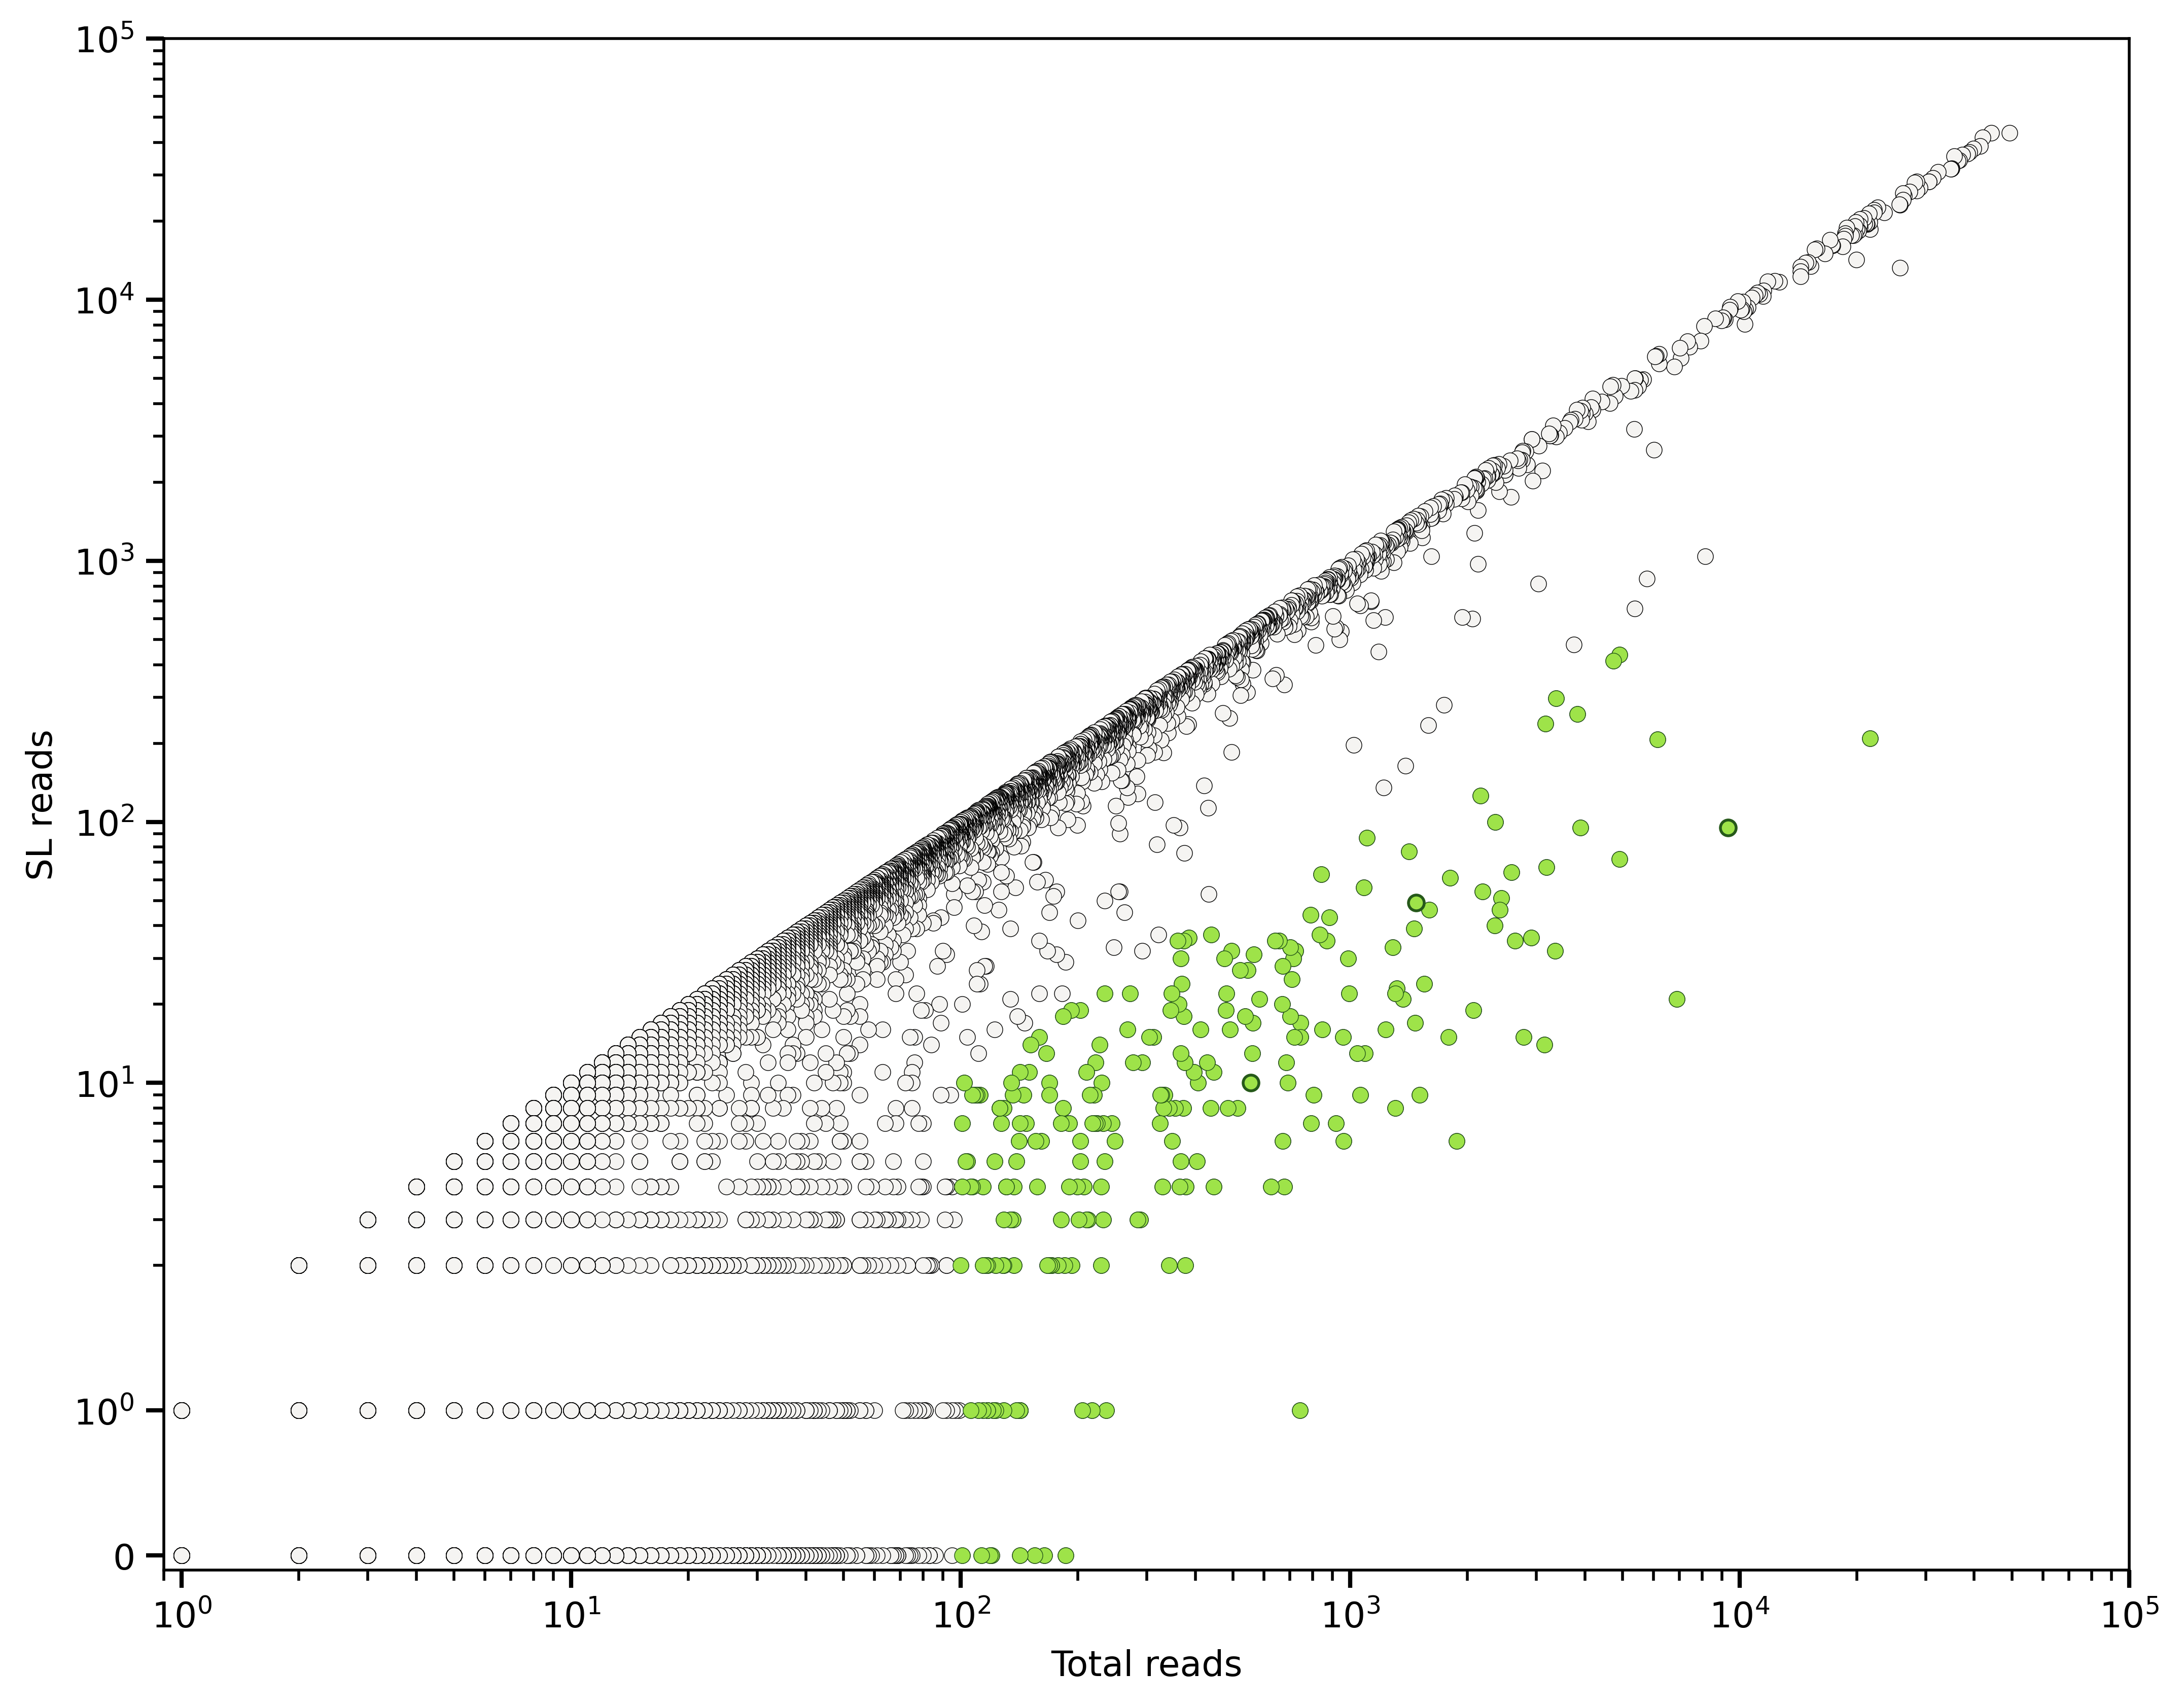

In [17]:
# for each, select the single most expressed position
most_exp_pos = genes_start.sort_values(['total','SL'], ascending=False).groupby('gene').head(1)

# coordinates for every genes
x = list(most_exp_pos['total'])
y = list(most_exp_pos['SL'])

# coordinates for genes with a position representated by 500+ reads and less than 10% SL 
selected = most_exp_pos[(most_exp_pos['total']>=100) & (most_exp_pos['%SL']<=10)]
sx = list(selected['total'])
sy = list(selected['SL'])

# Three genes of interest
ex = selected[selected['gene'].isin(['C42D8.2', 'F26F12.1', 'R12H7.2'])]
ex_x = list(ex['total'])
ex_y = list(ex['SL'])

# Generate plot
%matplotlib inline

#sns.set_style('white')

sns.set_style()
plt.figure(figsize=(10, 8), dpi=500)

# plot all
plt.scatter(x, y, s=20, c='#f5f4f2', edgecolor='k', linewidth=0.2)

# plot selected
plt.scatter(sx, sy, s=20, c='#9ee349', edgecolor='#26591A', linewidth=0.2)

# plot examples
plt.scatter(ex_x, ex_y, s=20, c='#9ee349', edgecolor='#26591A', linewidth=0.8)


# plot settings
plt.xlabel('Total reads')
plt.ylabel('SL reads')

plt.xscale('log')
plt.yscale('symlog', subs=[2,3,4,5,6,7,8,9])

plt.xlim(0.9, 10**5)
plt.ylim(-0.1, 10**5)

plt.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5, bottom=True, left=True)
plt.tick_params(axis='y', which ='minor', direction='out', length=3, width=0.8, colors='black', grid_alpha=0.5, left=True)
plt.tick_params(axis='y', which ='major', direction='out', length=5, width=1.2, colors='black', grid_alpha=0.5, left=True)
plt.tick_params(axis='x', which ='minor', direction='out', length=3, width=0.8, colors='black', grid_alpha=0.5, bottom=True)
plt.tick_params(axis='x', which ='major', direction='out', length=5, width=1.2, colors='black', grid_alpha=0.5, bottom=True)

# save
plt.savefig('Fig4.b-trans-splicing_detection_level_at_main_start_positions.png', bbox_inches='tight', dpi=800)

<font size="4">**Figure 4.b:**<br></font>
Trans splicing detection level. For each gene we identified the most frequently detected 5’ alignment starting position and plotted the number of reads at this position vs the number of those reads for which a splice Leader sequence could be detected. Genes for which the most represented start position had at least 100 reads but less than 10% SL detection are represented in green.

<br>

# Panel c: 5’ stem loop structure

In [18]:
# Example of three genes presenting hairpin:

# vit-2 (C42D8.2)
# col-140 (F26F12.1)
# asp-4 (R12H7.2)

selected[selected['gene'].isin(['C42D8.2', 'F26F12.1', 'R12H7.2'])]

,gene,position,total,SSP,%SSP,SL,HAIRPIN,UNIDENTIFIED,%SL,%HAIRPIN,%UNIDENTIFIED,SL1_variants,SL2_variants,SL2_ratio
433239,F26F12.1,5836834,9333,587,6.29,95,6174,3064,1.02,66.15,32.83,8,8,0.5
226900,C42D8.2,5105433,1475,13,0.88,49,904,522,3.32,61.29,35.39,3,3,0.5
846279,R12H7.2,13221439,555,11,1.98,10,431,114,1.80,77.66,20.54,0,0,NaN


<font size="4">**Figure 4.c:**<br></font>
Poorly trans spliced mRNA have a propensity to form a 5’ stem loop structure (termed here as "hairpin").